In [1]:
from __future__ import print_function

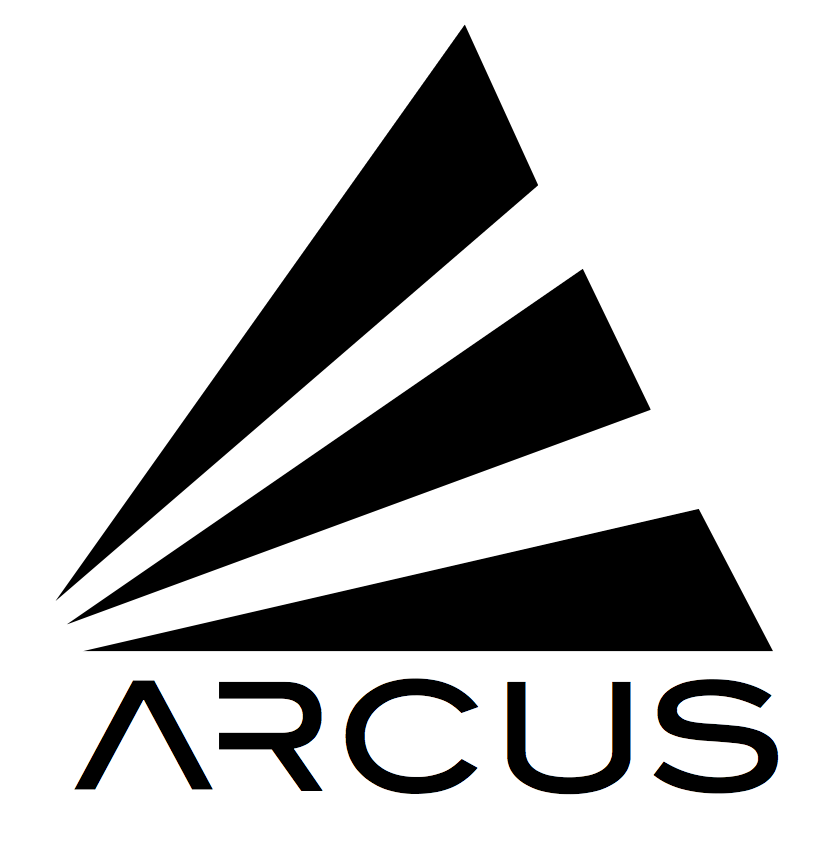

### Revision status: *initial draft*
Last revision in version control:

- Author: Hans Moritz Guenther <hgunther@mit.edu>
- commit 8e66b8b9a7a3810cad6cbff3b2d2ba58be57a257
- Date:   Wed Sep 27 10:25:01 2017 -0400

**The version shown here is modified compared to the last commited revision.**

            

This document is git version controlled. The repository is available at https://github.com/hamogu/arcus.
See git commit log for full revision history.

Code was last run with:

- MARXS ray-trace code version 1.2.dev643 (commit hash: c7a3e480d6 from 2018-06-26)
- ARCUS python code version 0.0.dev153 (commit hash: 3d289c95aa from 2018-02-07)
- ARCUS CALDB version hash: 5590a73 (commited on 2018-05-15 )


In [2]:
from nbtemplate import display_header, display_codetoggle, get_path
display_header('SelectRowlandParameters.ipynb', status='initial draft')

# Goal

The goal of this study is to optimize the parameters of the Rowland torus. There are several pieces of information that constrain our choice of parameters for the Rowland torus, most importantly engineering constraints that limit the area available to place the SPO channels in the focal plane. Moving the channels too close together will lead to overlapping mounting structures, moving them too far apart requires a larger spacecraft boom. 

Here, I present ray-traces for Arcus that explore a reasonable parameter space in the following parameters:

- channel spacing (measured center to center and given in mm)
- blaze angle (measured in degrees)
- Radius of Rowland Torus (measured in mm)

The remaining parameter is the distance between an on-axis grating and the focal point. Here, I have chosen a fixed value of 11800 mm. This will place the actual Arcus gratings (which are not located on-axis) a little more than 200 mm from the nodal plane of the mirrors. Adjusting this by a few cm has very little influence on the instrument performance and thus is can be fine-tuned after the remaining parameters are chosen.

# Caveats

The analysis presented here is based on full ray-trace calculations but there are a few simplifications for speed and ease of set-up compared to the full Arcus instrument. I list the most important ones here:

- No misalignments: The simulations below assume an ideal placement of SPOs and CAT gratings with zero mis-alignments. Typically, misalignments impact the spectral resolving power more than the effective area so it seems **wise to chose a configuration that performs better than the mission baseline requirements to leave room for an error budget**.
- No chip gaps: The calculations of the effective area assume two continuous strips of CCDs. In reality, there will be ~ 2 mm gaps between the CCDs, leading to drops in the effective area. This can be somewhat mitigated by shifting one of the two CCDs strips by 3-5 mm compared to the position simulated here. This will have a very small impact on the effective area, but it avoids the problem that an important wavelength might fall into a chip gap in all channels at the same time. The other strategy that can be employed is dithering, which smears out this gap over a larger wavelength range. Still, **the final effective area will a little lower then the curves shown here** (probably ~10 % for narrow regions of the spectrum or a few % for wider regions with dithering).
- CCDs are curved: In these simulations I employ a cylindrical detector that follows the Rowland circle exactly. The real Arcus detector will consist of flat CCDs that are tiled and deviate slightly from the Rowland circle, thus reducing the spectral resolving power a little. This is a very small effect.
- I did not yet have time to optimize plots and text. There certainly are missing labels, overlapping axis tick marks etc. Try to read around it and let me know if you cannot figure it out.

# Channel spacing

The grid of models that I have run includes a range of channel spacings, but from an engineering point of view a small distance between channels is strongly preferred, because it allows the use of a smaller boom. I did some initial exploration of this, but it seems that we can match the mission baseline requirements with a channel spacing that allows us to use a relatively small boom, so I will concentrate on that in the following and almost all plots are done for a channel spacing of 600 mm (measured center-to-center).

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table

from marxs.analysis import gratings as anagrat
from arcus import analyze_design as ad

%matplotlib inline

In [4]:
filepath = get_path('grid2designtorus')
sumtab = Table.read(os.path.join(filepath, 'summary.fits'), hdu=1)
wave = Table.read(os.path.join(filepath, 'summary.fits'), hdu=2)['wave']
orders = Table.read(os.path.join(filepath, 'summary.fits'), hdu=3)['col0']
sumtab['aeff_per_order'] = sumtab['aeff'][..., None] * (sumtab['prob_per_order'] / 
                                                        sumtab['prob_per_order'].sum(axis=2)[..., None])

Reading config file with path definitions: ['../site.cfg']


In [5]:
def res_aeff_in_region(tab, wave, wavelim, min_res):
    '''Summarize Aeff and resolving power in a given spectral region because this is the way the requirements
    in the Science Traceability Matrix are defined.
    
    This function identifies all orders that have a spectral resolving power > min_res and then adds up the 
    effective areas over all orders and averages them over the wavelength range.
    The spectral resolving power over all orders for a given wavelength is averaged weighted by the appropriate
    effective area and then averaged over all wavelengths in the selected region.
    '''
    indwave = (wave >= wavelim[0]) & (wave <= wavelim[1])
    indres = np.isfinite(tab['res_per_order']) & (tab['res_per_order'] > min_res)
    res_per_order = np.ma.array(sumtab['res_per_order'], mask= ~indwave[None, :, None] | ~indres)
    aeff_per_order = np.ma.array(sumtab['aeff_per_order'], mask= ~indwave[None, :, None] | ~indres)
    aeff = aeff_per_order.sum(axis=2).mean(axis=1)
    res = ((res_per_order * aeff_per_order).sum(axis=2) / aeff_per_order.sum(axis=2)).mean(axis=1)
    return res, aeff

In [6]:
# Note that the traceability matrix is not very ordered.
# Sometimes the Aeff required given and then the resolving power and sometimes the other way around.
res, aeff = res_aeff_in_region(sumtab, wave, [21.1, 28.], 100.)
sumtab['G1-1 (a)'] = res
sumtab['G1-1 (b)'] = aeff

res, aeff = res_aeff_in_region(sumtab, wave, [33.7, 40.], 100.)
sumtab['G1-1 (d)'] = res
sumtab['G1-1 (c)'] = aeff

res, aeff = res_aeff_in_region(sumtab, wave, [16., 21.6], 2000.)
sumtab['G1-2 (b)'] = res
sumtab['G1-2 (a)'] = aeff

res, aeff = res_aeff_in_region(sumtab, wave, [12., 50.], 1500.)
sumtab['G1-2 (b)'] = res
sumtab['G1-2 (c)'] = aeff


/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


In [7]:
def plot_phi_hist(ax, p):
    p_order = p['order', 'phi_folded', 'probability'].group_by('order')
    bins = np.linspace(0, .19, 41)
    sl = slice(-1, 2, -1)
    phis = [g['phi_folded'] for g in p_order.groups]
    probs = [g['probability'] for g in p_order.groups]
    ax.hist(phis[sl], weights=probs[sl], bins=bins, stacked=True, 
            label=[np.int(np.abs(k[0])) for k in p_order.groups.keys[sl]], rwidth=1, ec='none')
    ax.legend(title='Order')
    ax.set_xlabel('dispersion angle [rad]')
    ax.set_ylabel('# photons')

In [8]:
def plot_aeff(ax, row, wave, order0, **kwargs):
    label = kwargs.pop('label', '__no_legend__')
    ax.plot(wave, row['aeff_per_order'][:, ~order0].sum(axis=1), label=label, **kwargs)
    ax.plot(wave, row['aeff_per_order'][:, order0], ':', label='__no_legend__', **kwargs)

In [9]:
from matplotlib import transforms

def plot_everything(p, rows, wave, orders, color='kbgrymcy'):
    
    order0 = (orders == 0)
    
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(141)
    trans1 = transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
    
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    
    plot_phi_hist(ax1, p)
               
    cax4 = ax4.hist2d(p['circ_phi'], p['circ_y'], weights=p['probability'], 
                      bins=[np.arange(-.15, .2,.01), np.arange(-2, +3, .1)],
                     cmap=plt.get_cmap('gist_heat_r'))
    colbar = fig.colorbar(cax4[3])
    colbar.set_label('counts / bin')
    trans4 = transforms.blended_transform_factory(ax4.transData, ax4.transAxes)
    
    
    for i, row in enumerate(rows):
        # This plot is in term of phi_folded
        ax1.plot([row['phi_start'], row['phi_stop']],
                     [.98 - i * 0.03, .98 - i * 0.03],  
                     transform=trans1, color=color[i], lw=4)
        # This plot is in term os phi, not phi_folded
        phim = p.meta['phi_m']    
        ax4.plot([phim + row['phi_start'], phim + row['phi_stop']],
                     [.98 - i * 0.03, .98 - i * 0.03],
                     transform=trans4, color=color[i], lw=4, label=row['scenario_name'])
        ax4.plot([phim - row['phi_start'], phim - row['phi_stop']],
                     [.98 - i * 0.03, .98 - i * 0.03],
                     transform=trans4, color=color[i], lw=4, label='__no_legend__')
        
        pdet = p[ad.between(p['phi_folded'], [row['phi_start'], row['phi_stop']])]
        plot_aeff(ax2, row, wave, order0, color=color[i])
        
        if i == 0:
            ax3.plot(wave, row['res_per_order'])
        ax3.plot(wave, row['res'], color=color[i], lw=4)

    ax1.set_xlim([0, None])
    ax2.set_ylabel('Aeff [cm$^2$]')
    ax2.set_xlabel('wavelength [$\AA$]')
    ax3.set_ylabel('Resolving power')
    ax3.set_xlabel('wavelength [$\AA$]')
    ax4.set_ylabel('cross-dispersion [mm]')
    ax4.set_xlabel('dispersion angle [rad]')
    ax4.legend(loc=(.4, .5))
    #ax4.set_ylim([-5, 1])
    #ax4.set_xlim([-.17, .17])
    fig.subplots_adjust(wspace=0.3)
    print('Blaze: {:3.1f} deg - d_channels: {:4.0f} mm - max_f: {:6.0f} mm'.format(p.meta['BLAZE'],
                                                                                  p.meta['D_CHAN'], 
                                                                                  p.meta['MAX_F']))
    print('circle r: {:6.0f} mm - torus R: {:6.0f} mm'.format(p.meta['CIRCLE_R'], p.meta['TORUS_R']))
    return fig

The result of each ray-trace is a file with detected rays, where each ray has some wavelength, probability of survival, and position on the detector. The ray-files simulate only one out of four channels. The location of the photons from the remaining channels can be calculated from symmetry. This requires that that two strips of 8 detectors (for a total of 16 CCDs) are placed symmetrically around the symmetry plane.

Different parameters can be optimized when placing the CCDs. I require that the zeroth order is detected and then optimize either the total number of photons or the number of photons around 22 $\AA$ (see G1-1 (b) in the science tracebility matrix). I will add different strategies at a later point for verification, but my experience is that G1-1 (b) and G1-1 (a) set the strictest requirements. The different CCD placement strategies that I tried give very similar answers, so I do not expect this to change the conclusions significantly.

For each simulation and each CCD placement strategy I obtain one set of detected photons and from these photons I derive effective area curves and resolving power curves, which are shown below. The numbers I derive are all "per spectral order" and in "resolving power per order" and "effective area per order". In practice though, only two or three order contribute significantly at any wavelengths, so looking an a summed effective area and resolving power that is averaged weighted by the effective area in each order is good enough for now.

The following figure displays results for one simulation. Several similar plots are shown below for different parameters.

*leftmost panel*: This is a histrogram of the dispersion angle measured from the plane of symmetry. This diagram is useful to understand the detector placement. In this particular case, the zero-order photons are at $\theta = 0.05$ radian. (Really, they are at $\theta = -0.05$ but since we have two symmetric detector strips, it is easier to show on the absolute value of $\theta$). The low orders are close to the plane of symmetry and the higher orders further away. The black, blue, and green bars in the top indicate the range of $\theta$ values that are covered by the detectors. The black line is a detector large enough to catch all photons and the blue and green lines are scenarios with two strips of 8 CCDs with slightly different positions. 

*middle left panel*: Effective area for the black, blue, and green scenario. Solid line is for dispersed photons (all orders added up) and the dotted line is for the zeroth order.

*middle right panel*: Resolving power. The thick lines show the averaged resolving power for all dispersed orders, weighted by the number of photons in them. The thin, colored lines are resolving powers for individual orders for the first case (black scenario). At any one wavelength, most photons concentrate in only two or three orders, so these lines are mostly useful to diagnose problems with the ray-trace or analysis.

*rightmost panel*: Detector image. Note that this is not to scale, the y-axis is enlarged. Again, the colored bars on the top indicate the range of dispersion angle covered by the CCDs. The simulations are for a single channel. If a second channel shares the optical axes, then there will be a distribution mirrored on the -5 mm line. The distribution of photons becomes wider fruther away from the zeroths order. This is due to the Rowland geometry, which optimizes the focus in dispersion direction at the cost of artifacts in the cross-dispersion direction. This also explains the banana shape.

Blaze: 1.8 deg - d_channels:  500 mm - max_f:  11880 mm
circle r:   5945 mm - torus R:   6000 mm


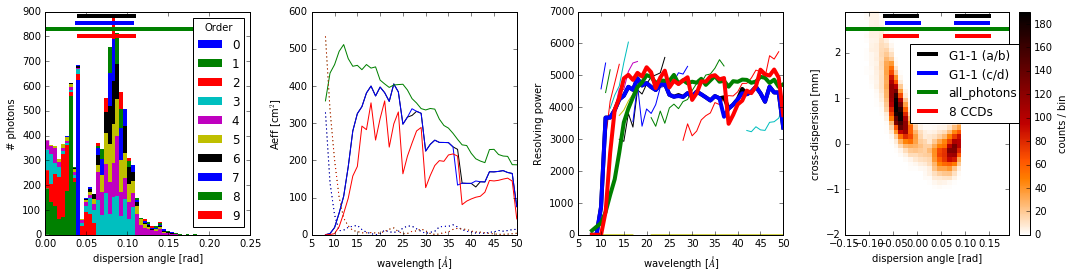

In [10]:
p = ad.load_prepare_table(os.path.join(filepath, os.path.basename(sumtab[30]['filename'])))
fig = plot_everything(p, sumtab[30: 34], wave, orders)

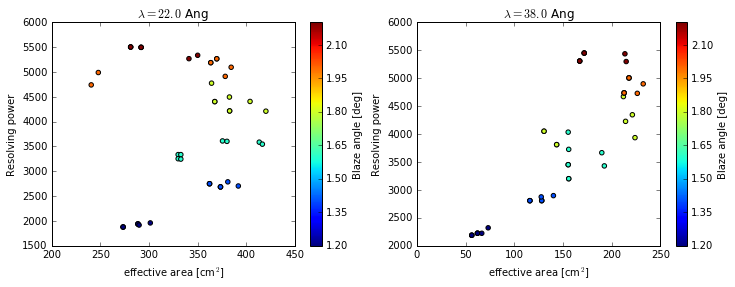

In [11]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for ax, j in zip([ax1, ax2], [14, 30]):
    t = sumtab[(sumtab['D_CHAN'] == 600)]
    cax = ax.scatter(t['aeff_per_order'][:, j, :-3].sum(axis=1), t['res'][:, j], c=t['BLAZE'])
    col = fig.colorbar(cax, ax=ax)
    ax.set_title('$\lambda = {}$ Ang'.format(wave[j]))
    col.set_label('Blaze angle [deg]')
    ax.set_xlabel('effective area [cm$^2$]')
    ax.set_ylabel('Resolving power')

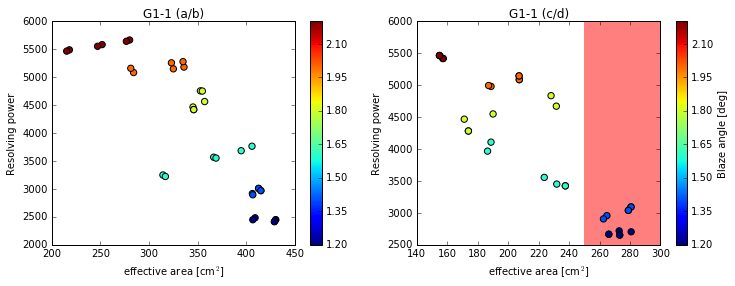

In [12]:
from matplotlib import patches

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

t = sumtab[((sumtab['D_CHAN'] == 600) | (sumtab['D_CHAN'] == 600) | (sumtab['D_CHAN'] == 600)) &
          (sumtab['scenario_name'] != 'all_photons') & (sumtab['TORUS_R'] > 5700)]

cax1 = ax1.scatter(t['G1-1 (b)'], t['G1-1 (a)'], s=(t['D_CHAN'] - 400) / 5, c=t['BLAZE'])
col = fig.colorbar(cax1, ax=ax1)
ax1.set_title('G1-1 (a/b)')

cax2 = ax2.scatter(t['G1-1 (c)'], t['G1-1 (d)'], s=(t['D_CHAN'] - 400) / 5, c=t['BLAZE'])
col = fig.colorbar(cax2, ax=ax2)
ax2.set_title('G1-1 (c/d)')

col.set_label('Blaze angle [deg]')
for ax in [ax1, ax2]:
    ax.set_xlabel('effective area [cm$^2$]')
    ax.set_ylabel('Resolving power')
 
def mark_requirements(ax, xmin, ymin, color):
    # add a rectangle
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    rect = patches.Rectangle([xmin, ymin], 1000, 10000, ec="none", fc=color, alpha=0.5, zorder=-5)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.add_patch(rect)
    
mark_requirements(ax1, 450, 2500, 'y')
mark_requirements(ax2, 250, 2000, 'r')

In [35]:
indblaze = (t['BLAZE'] > 1.55) & (t['BLAZE'] < 1.85)
indchan = (t['D_CHAN'] == 600.)
indtor = (t['TORUS_R'] == 5900.)
ind11ab = (t['scenario_name'] == 'G1-1 (a/b)')
ind11cd = (t['scenario_name'] == 'G1-1 (c/d)')
t18 = t[indblaze & indchan & indtor & (ind11ab | ind11cd)]

In [36]:
t18

BLAZE,CIRCLE_R,D_CHAN,MAX_F,TORUS_R,aeff [43],filename,phi_start,phi_stop,"prob_per_order [43,13]",res [43],"res_per_order [43,13]",scenario_name,"aeff_per_order [43,13]",G1-1 (a),G1-1 (b),G1-1 (d),G1-1 (c),G1-2 (b),G1-2 (a),G1-2 (c)
float64,float64,float64,float64,float64,float64,str20,float64,float64,float64,float64,float64,str11,float64,float64,float64,float64,float64,float64,float64,float64
1.6,5947.57093274,600.0,11880.0,5900.0,679.031970037 .. 132.964404066,0600_01.6_05900.fits,0.0171712721951,0.0837530758386,0.892772197611 .. 18.5414578142,335.04582036 .. 2919.80421468,nan .. 0.0181164912191,G1-1 (a/b),1.45948064643 .. 30.3110904537,3681.48630143,394.540070257,3965.09843803,186.400507479,4022.630392,408.613711034,255.914138625
1.6,5947.57093274,600.0,11880.0,5900.0,680.793169711 .. 132.964404066,0600_01.6_05900.fits,0.00219036637527,0.0687721700188,0.892772197611 .. 18.5414578142,334.179062854 .. 2919.80421468,nan .. 0.0181164912191,G1-1 (c/d),1.45948064643 .. 30.3110904537,3246.40446969,314.205778495,3420.54670145,237.521169749,3562.21012595,331.600497057,211.296558684
1.8,5947.57093274,600.0,11880.0,5900.0,779.010544127 .. 83.8484807817,0600_01.8_05900.fits,0.0263262701961,0.0929080738396,0.144848389177 .. 9.22786232929,232.526630302 .. 3204.84550249,nan .. 0.00925298875008,G1-1 (a/b),0.236794359452 .. 15.0854680662,4464.83598306,345.072383154,4466.18393298,171.10436295,4514.74233727,374.720018834,236.311907035
1.8,5947.57093274,600.0,11880.0,5900.0,316.291287682 .. 170.651700039,0600_01.8_05900.fits,0.042971721107,0.109553524751,0.144848389177 .. 9.22786232929,0.0 .. 4460.75729873,nan .. 0.00925298875008,G1-1 (c/d),0.236794359452 .. 15.0854680662,4754.2427333,352.715619017,4834.83355186,228.126499924,4775.80657749,384.996421827,256.709988025


Blaze: 1.6 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5900 mm


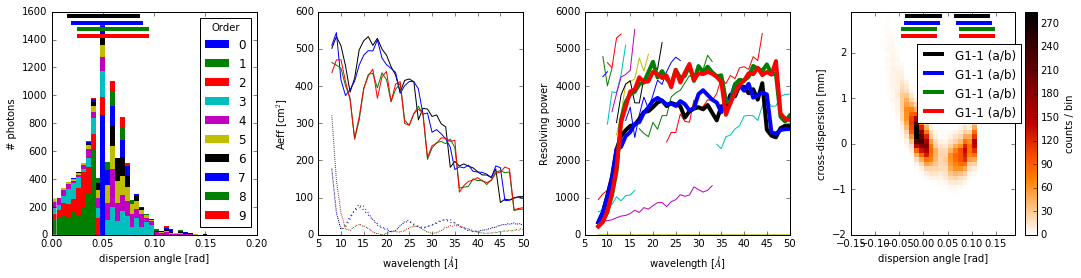

In [15]:
p = ad.load_prepare_table(os.path.join(filepath, os.path.basename(t18[0]['filename'])))
fig = plot_everything(p, t18, wave, orders)

Blaze: 1.8 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5900 mm


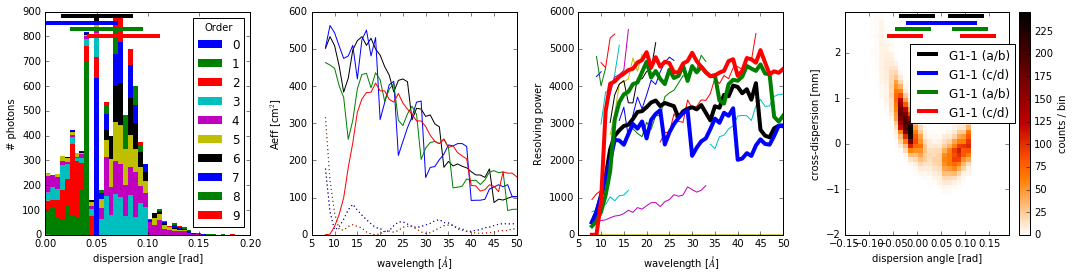

In [42]:
p = ad.load_prepare_table(os.path.join(filepath, os.path.basename(t18[2]['filename'])))
fig = plot_everything(p, t18, wave, orders)

Blaze: 1.6 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   6000 mm


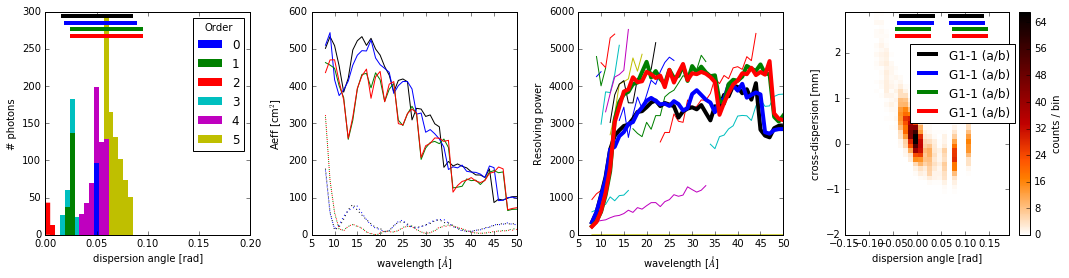

In [17]:
p = ad.load_prepare_table(os.path.join(filepath, os.path.basename(t18[1]['filename'])))
fig = plot_everything(p[(p['wave'] > 21.6) & (p['wave'] <= 28.)], t18, wave, orders)

Blaze: 1.6 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   6000 mm


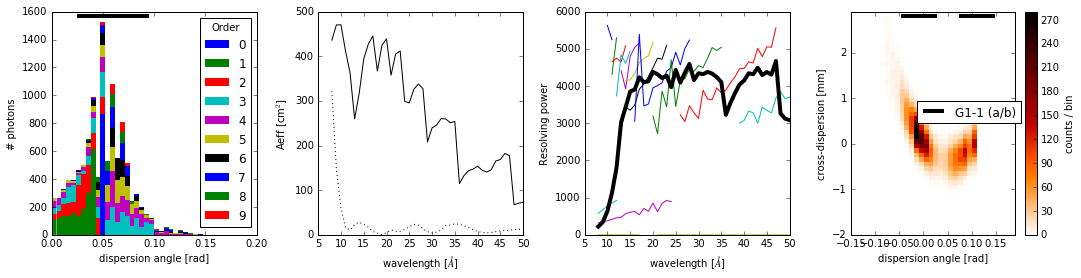

In [18]:
fig = plot_everything(p, t18[3::4], wave, orders)

This figure shows the effective area and resolving power in the wavelength range of science requirements G1-1 (a/b) (left) and G1-1 (c/d) (right). (Strictly speaking the requirements call for averages over a range of wavelengths, while these graphs are for a specific wavelength, but the functions are smooth enough that that does not make a major difference. It;s easy to calculate, but it's 9:30 om and I'm hungry and want to go home so that will have to wait for another day.)

The color of the dots shows the blaze angle of this particular simulation. For each blaze angle, there are simulations with different rotation axes for the torus (and therefor different torus R values) and different CCD placements. According to the proposal the baseline requirements for the left figure are $A_\mathrm{eff} > 450$ cm$^2$ and $\lambda/\Delta\lambda =2500$ and $A_\mathrm{eff} > 250$ cm$^2$ and $\lambda/\Delta\lambda =2000$ for the right figure. Blaze angles in the range of 1.7-1.9 deg reach these requirements with enough margin to account for the caveats listed above.

The following plots show several of the scenarios in this range in more detail. In these cases, the black, blue, and green scenarios in each figure differ by the radius of the Rowland torus (or the tilt angle); they all the the same number of CCDs. (The histogram in the leftmost figure only shows the distribution for the black scenario, this can be slightly different for the other Rowland torus radii.)

In [19]:
tab600 = sumtab[(sumtab['D_CHAN'] == 600) & (sumtab['scenario_name'] == 'G1-1 (a/b)')]

Blaze: 1.6 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5900 mm


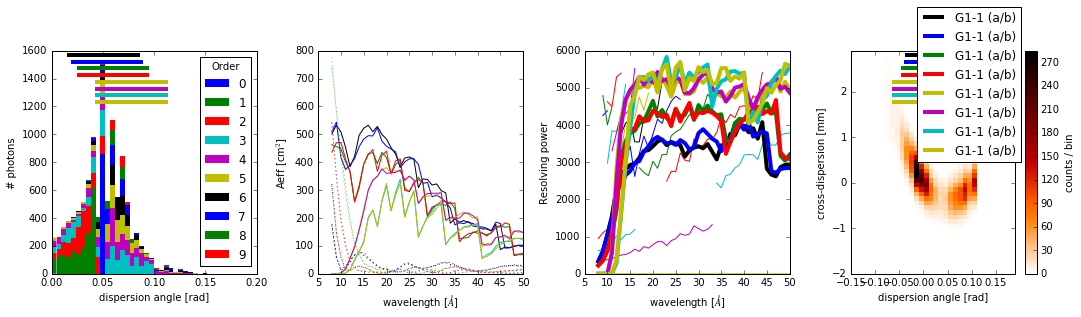

In [20]:
p = ad.load_prepare_table(os.path.join(filepath, os.path.basename(tab600[4]['filename'])))
fig = plot_everything(p, tab600[4:], wave, orders)

In [21]:
tab600 = sumtab[(sumtab['D_CHAN'] == 600) & #(sumtab['scenario_name'] == 'G1-1 (c/d)') & 
                (sumtab['BLAZE'] > 1.75)  & (sumtab['BLAZE'] < 1.85)]

## Plots for publications
Below are a few plots from the notebook above that are optimized for print in publications with e.g. manual modification of plot limits or font sizes.

Blaze: 1.8 deg - d_channels:  600 mm - max_f:  11880 mm
circle r:   5948 mm - torus R:   5900 mm
Reading config file with path definitions: ['../site.cfg']


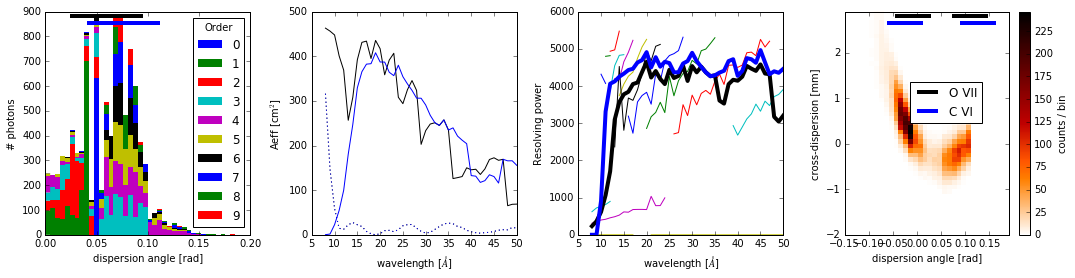

In [49]:
p = ad.load_prepare_table(os.path.join(filepath, os.path.basename(t18[2]['filename'])))
fig = plot_everything(p, t18[2:], wave, orders)
ax4 = fig.axes[3]
leg = ax4.get_legend()
leg.get_texts()[0].set_text('O VII')
leg.get_texts()[1].set_text('C VI')
#leg.get_texts()[2].set_text('O VII (1.8$^\circ$)')
#leg.get_texts()[3].set_text('C VI (1.8$^\circ$)')

fig.savefig(os.path.join(get_path('figures'), 'selectrowland.pdf'), bbox_inches='tight') 

Reading config file with path definitions: ['../site.cfg']


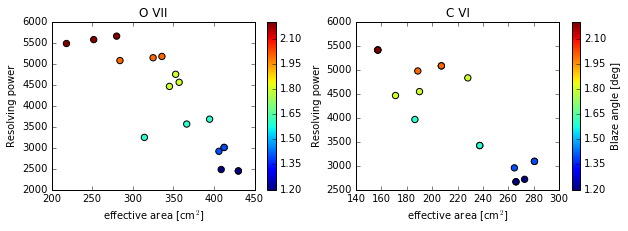

In [47]:
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

t = sumtab[(sumtab['D_CHAN'] == 600) & (sumtab['scenario_name'] != 'all_photons') & (sumtab['TORUS_R'] == 5900)]

cax1 = ax1.scatter(t['G1-1 (b)'], t['G1-1 (a)'], s=(t['D_CHAN'] - 400) / 5, c=t['BLAZE'])
col = fig.colorbar(cax1, ax=ax1)
ax1.set_title('O VII')

cax2 = ax2.scatter(t['G1-1 (c)'], t['G1-1 (d)'], s=(t['D_CHAN'] - 400) / 5, c=t['BLAZE'])
col = fig.colorbar(cax2, ax=ax2)
ax2.set_title('C VI')

col.set_label('Blaze angle [deg]')
for ax in [ax1, ax2]:
    ax.set_xlabel('effective area [cm$^2$]')
    ax.set_ylabel('Resolving power')
    
fig.savefig(os.path.join(get_path('figures'), 'selectrowland2.pdf'), bbox_inches='tight') 

In [22]:
display_codetoggle()